In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
from model import *
from dataset import *
import util
import json
from collections import defaultdict

# Evaluate the model on the entire dataset
data = HD5Dataset('../data/data_dragon.hd5', seed=42, features=["FirstCharge", "CumulativeCharge", "Time",
            "VertexX", "VertexY", "VertexZ", "RecoX",
"RecoZ", "RecoAzimuth", "RecoZenith"])

In [2]:
with open('training/gcnn_grid/hd5_937968/config.json') as f:
    settings = json.load(f)

In [3]:
data = util.dataset_from_config(settings)

0 of 1, slice 0:42328120

Loaded feature ChargeFirstPulse
0 of 1, slice 0:42328120

Loaded feature TimeFirstPulse
0 of 1, slice 0:42328120

Loaded feature ChargeLastPulse
0 of 1, slice 0:42328120

Loaded feature TimeLastPulse
0 of 1, slice 0:42328120

Loaded feature TimeVariance
0 of 1, slice 0:42328120

Loaded feature IntegratedCharge
0 of 1, slice 0:42328120

Loaded feature VertexX
0 of 1, slice 0:42328120

Loaded feature VertexY
0 of 1, slice 0:42328120

Loaded feature VertexZ
0 of 14, slice 0:100000000

1 of 14, slice 100000000:200000000

2 of 14, slice 200000000:300000000

3 of 14, slice 300000000:400000000

4 of 14, slice 400000000:500000000

5 of 14, slice 500000000:600000000

6 of 14, slice 600000000:700000000

7 of 14, slice 700000000:800000000

8 of 14, slice 800000000:900000000

9 of 14, slice 900000000:1000000000

10 of 14, slice 1000000000:1100000000

11 of 14, slice 1100000000:1200000000

12 of 14, slice 1200000000:1300000000

13 of 14, slice 1300000000:1300223452

Create

In [4]:
model = util.model_from_config(settings)

In [8]:
model.load_weights('training/gcnn_grid/hd5_937968/model_weights.h5')

In [9]:
model.weights

[<tf.Variable 'gaussian_adjacency_matrix/sigma:0' shape=(1,) dtype=float32, numpy=array([-0.2420903], dtype=float32)>,
 <tf.Variable 'graph_convolution/dense/kernel:0' shape=(18, 64) dtype=float32, numpy=
 array([[ 0.04942197,  0.30179748, -0.29704058, ...,  0.2629831 ,
         -0.05758577, -0.01252191],
        [-0.24843208, -0.21780916,  0.01035598, ..., -0.05979322,
         -0.07838951, -0.28137332],
        [-0.10069472,  0.03503263,  0.10362906, ...,  0.16908003,
         -0.2685849 ,  0.09297854],
        ...,
        [-0.29367134, -0.4732373 ,  0.5204175 , ...,  0.16613512,
          0.11012596,  0.386512  ],
        [-0.15725107, -0.6174088 ,  0.5545506 , ...,  0.618746  ,
          0.7374874 ,  0.45177376],
        [-0.14825034,  0.0618745 ,  0.25878832, ...,  0.37859663,
          0.12681857,  0.4293634 ]], dtype=float32)>,
 <tf.Variable 'graph_convolution/dense/bias:0' shape=(64,) dtype=float32, numpy=
 array([ 0.00827637,  0.08294237,  0.32067743, -0.02497393, -0.06330106

In [74]:
data.get_baseline_accuracy()

0.6165341177325053

In [10]:
test_idx = data._get_idx('test')

In [11]:
# Evaluate the model on all the data
batch_size = 128
logits_model = model.predict_generator(data.get_batches(batch_size=batch_size, dataset='test'),
                       steps=int(np.ceil(data.size(dataset='test') / batch_size)))

In [190]:
logits_model

array([[0.5095678 ],
       [0.55883044],
       [0.56532955],
       ...,
       [0.5948496 ],
       [0.5494186 ],
       [0.58049643]], dtype=float32)

In [191]:
np.unique(logits_model).shape

(210292,)

In [192]:
y_model = (logits_model >= 0.5).astype(np.int)

In [193]:
np.unique(y_model)

array([0, 1])

In [194]:
y_model = y_model.squeeze()

In [195]:
# Get the pe counts (~charge) of the test data
total_charge = data.file['TotalCharge']['value'][test_idx]

In [218]:
y_gnd = data.targets[test_idx]
y_baseline = (data.delta_loglikelihood[test_idx] >= 2.0).astype(np.uint8)

In [219]:
total_charge
total_charge.max(), total_charge.min()

(1273.3749921172857, 7.0)

In [220]:
bins = np.logspace(0.8, 3.2)
binned = np.digitize(total_charge, bins)
#np.unique(binned)

In [221]:
def get_metrics(y_pred, y_gnd):
    acc = (y_pred == y_gnd).sum() / len(y_pred)
    tpr = (y_pred[y_gnd == 1] == 1).sum() / ((y_gnd == 1).sum() + 1e-20)
    tnr = (y_pred[y_gnd == 0] == 0).sum() / ((y_gnd == 0).sum() + 1e-20)
    ppr = (y_pred == 1).sum() / y_pred.shape[0]
    return acc, tpr, tnr, ppr

In [222]:
pgd_encoding = np.array(data.file['PDGEncoding']['value'], dtype=np.uint8).astype(np.int8)
pgd_encoding.shape

(2202957,)

In [223]:
(np.abs(pgd_encoding) == 12).sum()

524922

In [224]:
interaction_types = np.array(data.file['InteractionType']['value'], dtype=np.uint8)
interaction_types

array([1, 1, 1, ..., 1, 2, 1], dtype=uint8)

In [225]:
np.unique(pgd_encoding, return_counts=True)

(array([-16, -14, -12,  12,  14,  16], dtype=int8),
 array([  46767,  467199,  164192,  360730, 1036437,  127632]))

In [226]:
np.logical_and((interaction_types == 1), (np.abs(pgd_encoding) == 14)).sum() / interaction_types.shape[0]

0.618337988440083

In [227]:
np.unique(interaction_types)

array([1, 2], dtype=uint8)

In [228]:
y_gnd2 = np.logical_and((interaction_types == 1), (np.abs(pgd_encoding) == 14)).astype(np.int)

In [229]:
metrics = defaultdict(lambda: defaultdict(list))
for bin_idx, value in enumerate(bins):
    for interaction_type, pgd_code in (('nue', 12), ('numu CC', 14), ('numu NC', 14), ('nutau', 16)):
        # print((np.abs(pgd_encoding) == pgd_code).sum(), pgd_code)
        bin_mask = binned == bin_idx
        enc_mask = np.abs(pgd_encoding[test_idx] == pgd_code)
        if 'numu' in interaction_type:
            it = 1 if 'CC' in interaction_type else 2
            it_mask = interaction_types[test_idx] == it
            #print(it, it_mask.sum())
            idxs = np.where(np.logical_and(bin_mask, np.logical_and(enc_mask, it_mask)))[0]
        else:
            idxs = np.where(np.logical_and(bin_mask, enc_mask))[0]
        # print(idxs.shape)
        for y, t in ((y_model, 'model'), (y_baseline, 'baseline')):
            acc, tpr, tnr, ppr = get_metrics(y[idxs], y_gnd[idxs])
            metrics[interaction_type][t].append({
                'acc' : acc, 'tpr' : tpr, 'ppr' : ppr, 'bin_idx' : bin_idx, 'value' : value, 'num_samples' : idxs.shape[0]
            })

/home/dominik/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in long_scalars
  
/home/dominik/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in long_scalars
  """


In [230]:
dfs = {
    pgd_code : {
            type_ : pd.DataFrame(data) for type_, data in metrics_code.items()
        } for pgd_code, metrics_code in metrics.items()
    }
for pgd_code, metrics_code in dfs.items():
    for type_, df in metrics_code.items():
        df = df[df['num_samples'] > 100]
        metrics_code[type_] = df

In [231]:
dfs['numu NC']

{'model':          acc  bin_idx  num_samples       ppr  tpr       value
 3   1.000000        3          137  0.000000  0.0    8.849908
 4   1.000000        4          299  0.000000  0.0    9.906457
 5   1.000000        5          432  0.000000  0.0   11.089142
 6   1.000000        6          570  0.000000  0.0   12.413023
 7   0.987118        7          621  0.012882  0.0   13.894955
 8   0.968796        8          673  0.031204  0.0   15.553808
 9   0.940058        9          684  0.059942  0.0   17.410704
 10  0.896552       10          696  0.103448  0.0   19.489286
 11  0.774845       11          644  0.225155  0.0   21.816019
 12  0.658249       12          594  0.341751  0.0   24.420531
 13  0.549470       13          566  0.450530  0.0   27.335983
 14  0.463938       14          513  0.536062  0.0   30.599497
 15  0.416149       15          483  0.583851  0.0   34.252626
 16  0.299320       16          441  0.700680  0.0   38.341886
 17  0.259901       17          404  0.740099 

In [250]:
def plot_metric(metric, metric_name):
    colors = ['blue', 'green', 'red', 'purple']
    fig = plt.figure()
    plt.xscale('log')
    for (pgd_code, df), color in zip(dfs.items(), colors):
        for t in df.keys():
            if t == 'model':
                plt.plot(df[t]['value'], df[t][metric], label=f'{pgd_code} (model)', color=color)
            else:
                plt.plot(df[t]['value'], df[t][metric], label=f'{pgd_code} (baseline)', linestyle='dashed', color=color)
    plt.legend(loc='left', bbox_to_anchor=(1.0, 1.05))
    plt.title(metric_name)
    plt.xlabel('log(Integrated Charge) (pe)')


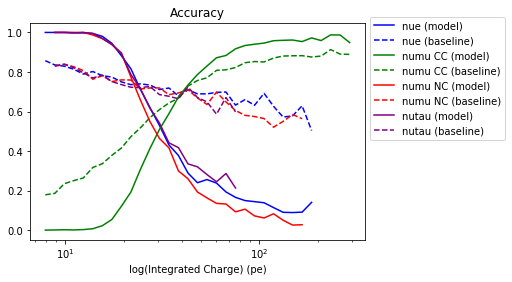

In [251]:
plot_metric('acc', 'Accuracy', )

In [252]:
y_model

array([1, 1, 1, ..., 1, 1, 1])

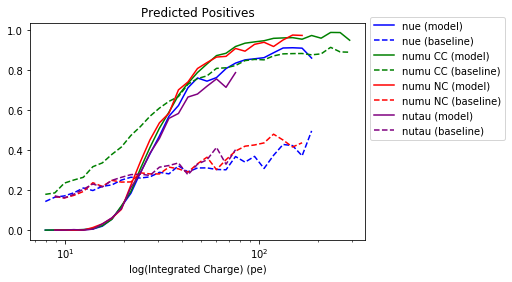

In [253]:
plot_metric('ppr', 'Predicted Positives')

In [249]:
np.hstack((
    np.array(pd.DataFrame(metrics['numu CC']['model'])['acc']),
    np.array(pd.DataFrame(metrics['numu CC']['model'])['acc'])
    )
)

TypeError: hstack() takes 1 positional argument but 2 were given

In [89]:
total_charge_sorted = np.sort(total_charge)

In [19]:
# Find different cutoff values to check performance at different maximal energies by selecting the quantiles of the data
cutoffs = []
quantiles = []
for quantile in np.arange(0.00, 1.0, 0.01):
    quantile = 1.0 - quantile
    quantiles.append(quantile)
    cutoffs.append(total_charge_sorted[int(total_charge.shape[0] * quantile) - 1])

In [20]:
y_model.shape, y_gnd.shape

((220295,), (220295,))

In [22]:
metrics = defaultdict(lambda: defaultdict(list))
for cutoff, quantile in zip(cutoffs, quantiles):
    mask = total_charge <= cutoff
    acc_baseline, tpr_baseline, tnr_baseline, ppr_baseline = get_metrics(y_baseline[mask], y_gnd[mask])
    metrics['baseline']['accuracy'].append(acc_baseline)
    metrics['baseline']['tpr'].append(tpr_baseline)
    metrics['baseline']['tnr'].append(tnr_baseline)
    metrics['baseline']['ppr'].append(ppr_baseline)
    acc_model, tpr_model, tnr_model, ppr_model = get_metrics(y_model[mask], y_gnd[mask])
    metrics['model']['accuracy'].append(acc_model)
    metrics['model']['tpr'].append(tpr_model)
    metrics['model']['tnr'].append(tnr_model)
    metrics['model']['ppr'].append(ppr_model)
    metrics['gnd']['ppr'].append((y_gnd[mask] == 1).sum() / y_gnd[mask].shape[0])

Text(0.5, 0.04, 'Integrated Charge (pe)')

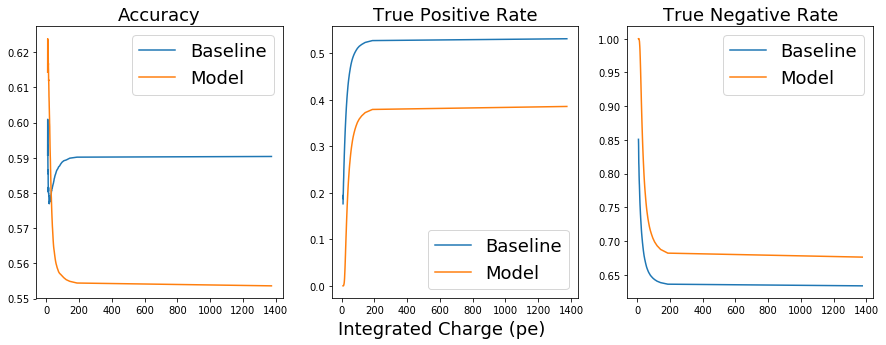

In [23]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(131)
ax1.plot(cutoffs, metrics['baseline']['accuracy'], label='Baseline')
ax1.plot(cutoffs, metrics['model']['accuracy'], label='Model')
ax1.set_title('Accuracy', fontsize=18)
ax1.legend(fontsize=18)
ax2 = fig.add_subplot(132)
ax2.plot(cutoffs, metrics['baseline']['tpr'], label='Baseline')
ax2.plot(cutoffs, metrics['model']['tpr'], label='Model')
ax2.set_title('True Positive Rate', fontsize=18)
ax2.legend(fontsize=18)
ax3 = fig.add_subplot(133)
ax3.plot(cutoffs, metrics['baseline']['tnr'], label='Baseline')
ax3.plot(cutoffs, metrics['model']['tnr'], label='Model')
ax3.set_title('True Negative Rate', fontsize=18)
ax3.legend(fontsize=18)
fig.text(0.5, 0.04, 'Integrated Charge (pe)', ha='center', va='center', fontsize=18)



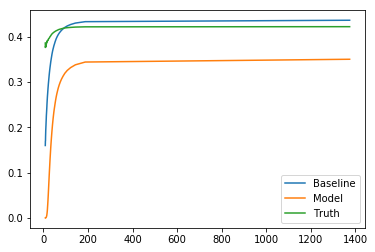

In [24]:
fig = plt.figure()
plt.plot(cutoffs, metrics['baseline']['ppr'], label='Baseline')
plt.plot(cutoffs, metrics['model']['ppr'], label='Model')
plt.plot(cutoffs, metrics['gnd']['ppr'], label='Truth')
plt.legend()


In [31]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
adjacency_matrix_layer_1 (Ad multiple                  1         
_________________________________________________________________
gcnn_block_4 (GCNNBlock)     multiple                  1088      
_________________________________________________________________
gcnn_block_5 (GCNNBlock)     multiple                  16448     
_________________________________________________________________
gcnn_block_6 (GCNNBlock)     multiple                  16448     
_________________________________________________________________
gcnn_block_7 (GCNNBlock)     multiple                  16448     
_________________________________________________________________
dense_2 (Dense)              multiple                  2080      
_________________________________________________________________
batch_normalization_v1_1 (Ba multiple                  128       
__________

In [32]:
model.weights

[<tf.Variable 'adjacency_matrix_layer_1/sigma:0' shape=(1,) dtype=float32, numpy=array([-1.1994079], dtype=float32)>,
 <tf.Variable 'gcnn_block_4/dense/kernel:0' shape=(16, 64) dtype=float32, numpy=
 array([[-6.7605382e-01, -5.5014306e-01,  1.0545670e+00, ...,
          5.9158012e-02,  4.1892594e-01,  1.1311057e+00],
        [-1.1726910e-01, -3.6698148e-02, -2.5776282e-02, ...,
         -1.6091052e-01, -3.3308864e-03,  1.9296408e-02],
        [-4.5562524e-01, -7.2932534e-02,  3.4593046e-01, ...,
         -2.7987896e-02,  1.9500892e-01,  7.2564250e-01],
        ...,
        [ 2.4853425e-02,  5.2007634e-02,  1.5153764e-04, ...,
         -1.7101361e-01,  9.0077855e-03, -3.0158782e-01],
        [ 1.8562905e-01, -2.1861477e-01, -2.6344028e-01, ...,
         -1.6159213e-01,  5.9850786e-02, -1.6955628e-01],
        [ 1.4021096e-01, -1.9073695e-01, -1.7653483e-01, ...,
          9.7623197e-03, -1.5720429e-02, -1.2895808e-01]], dtype=float32)>,
 <tf.Variable 'gcnn_block_4/dense/bias:0' shape=(6

In [131]:
np.unique(y_model)

array([0])

# Investigate attributes of the dataset

In [5]:
file = h5py.File('../data/data_dragon2.hd5')

In [13]:
idx = np.arange(file['TimeStdDeviation'].shape[0])
np.random.shuffle(idx)

In [14]:
samples = idx[:100000]

In [18]:
file.keys()

<KeysViewHDF5 ['ChargeFirstPulse', 'ChargeLastPulse', 'DeltaLLH', 'IC86_Dunkman_L6_SANTA_DirectCharge', 'IntegratedCharge', 'InteractionType', 'NumberChannels', 'NumberVertices', 'Offset', 'PDGEncoding', 'RecoAzimuth', 'RecoX', 'RecoY', 'RecoZ', 'RecoZenith', 'TimeFirstPulse', 'TimeLastPulse', 'TimeStdDeviation', 'TotalCharge', 'VertexX', 'VertexY', 'VertexZ', '__I3Index__']>

In [42]:
time_std_samples = file['TimeStdDeviation']['item'][samples]

In [38]:
time_std_samples = time_std_samples[time_std_samples < 1e-5]

In [43]:
time_std_samples

array([1.2055448e-03, 1.1102230e-16, 0.0000000e+00, ..., 0.0000000e+00,
       0.0000000e+00, 2.8057413e-03], dtype=float32)

(array([76768.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,  4604.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,   264.]),
 array([0.00000000e+00, 2.22044600e-18, 4.44089200e-18, 6.66133800e-18,
        8.88178400e-18

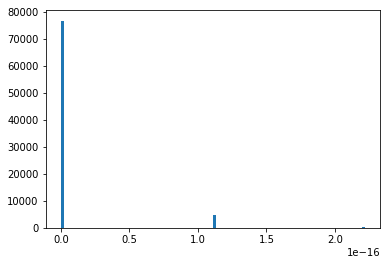

In [39]:
plt.hist(time_std_samples, bins=100)

In [40]:
charge_samples = file['ChargeFirstPulse']['item'][samples]

In [27]:
charge_samples = charge_samples[charge_samples <= 5]

(array([3072., 3387., 3761., 4108., 4557., 5143., 5673., 5869., 6233.,
           0., 6162., 6139., 5778., 5318., 4768., 4331., 3793., 3172.,
           0., 2688., 2301., 1654., 1348., 1078.,  891.,  731.,  589.,
           0.,  528.,  435.,  373.,  360.,  345.,  307.,  296.,  278.,
           0.,  259.,  222.,  214.,  202.,  214.,  174.,  185.,  134.,
           0.,  137.,  121.,  134.,   90.,  136.,   94.,   87.,   85.,
           0.,   75.,   86.,   84.,   47.,   75.,   48.,   55.,   42.,
           0.,   39.,   36.,   49.,   49.,   39.,   48.,   36.,   37.,
           0.,   32.,   27.,   32.,   32.,   41.,   35.,   43.,   27.,
           0.,   28.,   21.,   21.,   24.,   27.,   20.,   18.,   13.,
           0.,   24.,   15.,   21.,   18.,   13.,   21.,   15.,   14.,
          11.]),
 array([0.525     , 0.56949997, 0.61399996, 0.65849996, 0.70299995,
        0.74749994, 0.792     , 0.8365    , 0.881     , 0.9255    ,
        0.96999997, 1.0145    , 1.059     , 1.1035    , 1.148     

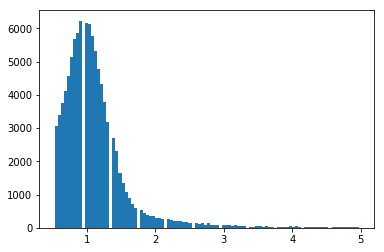

In [29]:
plt.hist(charge_samples, bins=100)

In [48]:
time_samples = file['TimeFirstPulse']['item'][samples]

In [51]:
time_samples_filtered = time_samples[time_samples > -0.002]

In [55]:
time_samples_filtered.std()

0.00030537526